This notebook will train an XGBoost regression model to predict dam fullness
you may not need to run this if you already have the model from the repo

In [1]:
from datetime import datetime
import pickle
import json
import glob
import os

from sklearn.metrics import mean_absolute_error, mean_tweedie_deviance
from xgboost import XGBRegressor
from bayes_opt import BayesianOptimization
import xgboost
import seaborn as sns; sns.set_theme(color_codes=True)
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [2]:
# path to training and validation data
training_data_path = os.path.join(os.getcwd(),'data/dam forecast train.csv')

val_data_path = os.path.join(os.getcwd(),'data/dam forecast val.csv')

In [3]:
# set location to save model
model_folder = os.getcwd()
model_name = 'dam_forecast_11-10-22.pkl'
model_path = os.path.join(model_folder,'data',model_name)
model_path

'/home/nick/Documents/Work code/Dam-Forecast/data/dam_forecast_11-10-22.pkl'

In [4]:
# we limit the max dam size as large dams are note well represented in our dataset 
max_value = 20000

In [5]:
# load up training data, do some cleaning/sorting
training_data = pd.read_csv(training_data_path)
training_data = training_data.reindex(sorted(training_data.columns), axis=1)
training_data = (training_data[training_data['dam_area'] < max_value])
training_data.replace([np.inf, -np.inf], 0, inplace=True)
training_data.head()

,SRC_DATE,acq_date_dec,acq_month,acq_year,class,class_name,dam_area,file_name,geometry,rain_0_months before,...,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before,water_area
0,20191216,2019.923077,12,2019,2,no water,1499.986376,arcgisonline_13466_pred_and_score.tif,POINT (150.7703260923624 -34.49997476956882),2.762451,...,20.396746,17.926054,15.415278,12.961130,13.086934,13.189901,16.016296,18.968658,21.853695,0.000000
1,20191216,2019.923077,12,2019,2,no water,1957.925202,arcgisonline_19956_pred_and_score.tif,POINT (150.7609417292462 -34.5194085769909),3.197464,...,20.336300,17.855085,15.332343,12.882524,13.011043,13.112334,15.936459,18.891691,21.774044,0.000000
2,20191216,2019.923077,12,2019,2,no water,56.557682,arcgisonline_29686_pred_and_score.tif,POINT (150.7921407085229 -34.48640159069117),2.658848,...,20.390297,17.952702,15.478308,13.054444,13.186954,13.291353,16.112299,19.028639,21.890549,0.000000
3,20191216,2019.923077,12,2019,0,dam and water,620.839041,arcgisonline_2208_pred_and_score.tif,POINT (150.8273026231211 -34.59007854166663),4.103868,...,19.747135,17.428568,15.065031,12.862777,13.064048,13.170877,15.932156,18.648500,21.329342,69.919793
4,20191216,2019.923077,12,2019,0,dam and water,911.591665,arcgisonline_43254_pred_and_score.tif,POINT (150.8025877887565 -34.57963568981891),3.889048,...,20.026794,17.639698,15.219195,12.937696,13.106893,13.211027,16.005402,18.805094,21.575476,85.853539


In [6]:
# load up validation data and do some cleaning/sorting
val_data = pd.read_csv(val_data_path)
val_data = val_data.reindex(sorted(val_data.columns), axis=1)
val_data = (val_data[val_data['dam_area'] < max_value])
val_data.replace([np.inf, -np.inf], 0, inplace=True)
val_data.head()

,SRC_DATE,acq_date_dec,acq_month,acq_year,class,class_name,dam_area,file_name,geometry,rain_0_months before,...,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before,water_area
0,20151012,2015.769231,10,2015,0,dam and water,1467.191148,arcgisonline_132898_pred_and_score.tif,POINT (117.3172965191077 -33.24564247144878),9.043823,...,12.835136,11.108263,10.531229,12.044368,12.067635,16.236391,20.395378,24.588543,23.805340,400.256079
1,20160808,2016.615385,8,2016,0,dam and water,7575.018970,arcgisonline_70618_pred_and_score.tif,POINT (152.9625759629707 -26.43549796464562),30.879414,...,16.208225,16.421938,19.850100,22.161938,24.166159,25.166771,24.075779,23.361519,23.210749,5781.220903
2,20150329,2015.230769,3,2015,0,dam and water,2028.126533,arcgisonline_84979_pred_and_score.tif,POINT (142.9804044837108 -37.77391478774938),22.954985,...,20.310444,18.668152,16.997301,15.661266,13.949310,11.053338,8.662997,8.203583,9.625609,581.212166
3,20151215,2015.923077,12,2015,0,dam and water,569.161178,arcgisonline_101081_pred_and_score.tif,POINT (145.618767566165 -38.4325091507143),37.716213,...,15.805417,15.925524,11.613432,9.590775,9.022965,10.216203,12.452333,14.021166,16.439243,317.463008
4,20160416,2016.307692,4,2016,0,dam and water,3367.296500,arcgisonline_125002_pred_and_score.tif,POINT (118.0078021793126 -30.57147183423009),31.052204,...,24.274788,26.393480,26.532434,24.433882,23.749607,21.477095,14.928035,12.299461,11.371953,508.559500


In [7]:
training_data.shape

(108847, 36)

In [8]:
val_data.shape

(12092, 36)

In [9]:
# set a list of columns to drop, the model will not see these
drop_list = ['water_area','file_name', 'SRC_DATE','geometry','acq_year','acq_month','acq_date_dec','class','class_name']

In [10]:
# remove the drop list and setup target df
train_X = training_data.drop(columns=drop_list)
train_y = training_data[['water_area']]
print(train_y.head())
train_X.head()

   water_area
0    0.000000
1    0.000000
2    0.000000
3   69.919793
4   85.853539


,dam_area,rain_0_months before,rain_10_months before,rain_11_months before,rain_12_months before,rain_1_months before,rain_2_months before,rain_3_months before,rain_4_months before,rain_5_months before,...,tavg_12_months before,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before
0,1499.986376,2.762451,36.125671,71.728584,69.268257,18.543798,32.006516,61.439262,35.894455,16.539648,...,22.234226,20.396746,17.926054,15.415278,12.961130,13.086934,13.189901,16.016296,18.968658,21.853695
1,1957.925202,3.197464,38.361225,75.389587,73.195740,19.394297,34.531719,64.828262,38.369305,17.053242,...,22.165726,20.336300,17.855085,15.332343,12.882524,13.011043,13.112334,15.936459,18.891691,21.774044
2,56.557682,2.658848,35.916077,69.969917,66.735779,18.249218,31.475410,60.696507,35.672646,16.840359,...,22.226084,20.390297,17.952702,15.478308,13.054444,13.186954,13.291353,16.112299,19.028639,21.890549
3,620.839041,4.103868,46.451984,76.181908,72.046654,19.497202,38.455097,70.509048,42.860733,19.531702,...,21.477997,19.747135,17.428568,15.065031,12.862777,13.064048,13.170877,15.932156,18.648500,21.329342
4,911.591665,3.889048,44.183247,76.219666,72.164078,19.490854,37.583042,69.094116,42.032280,18.774553,...,21.803089,20.026794,17.639698,15.219195,12.937696,13.106893,13.211027,16.005402,18.805094,21.575476


In [11]:
# setup validation sets
val_X = val_data.drop(columns=drop_list)
val_y = val_data[['water_area']].copy()
print(train_y.head())
print(train_X.shape)
train_X.head()

   water_area
0    0.000000
1    0.000000
2    0.000000
3   69.919793
4   85.853539
(108847, 27)


,dam_area,rain_0_months before,rain_10_months before,rain_11_months before,rain_12_months before,rain_1_months before,rain_2_months before,rain_3_months before,rain_4_months before,rain_5_months before,...,tavg_12_months before,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before
0,1499.986376,2.762451,36.125671,71.728584,69.268257,18.543798,32.006516,61.439262,35.894455,16.539648,...,22.234226,20.396746,17.926054,15.415278,12.961130,13.086934,13.189901,16.016296,18.968658,21.853695
1,1957.925202,3.197464,38.361225,75.389587,73.195740,19.394297,34.531719,64.828262,38.369305,17.053242,...,22.165726,20.336300,17.855085,15.332343,12.882524,13.011043,13.112334,15.936459,18.891691,21.774044
2,56.557682,2.658848,35.916077,69.969917,66.735779,18.249218,31.475410,60.696507,35.672646,16.840359,...,22.226084,20.390297,17.952702,15.478308,13.054444,13.186954,13.291353,16.112299,19.028639,21.890549
3,620.839041,4.103868,46.451984,76.181908,72.046654,19.497202,38.455097,70.509048,42.860733,19.531702,...,21.477997,19.747135,17.428568,15.065031,12.862777,13.064048,13.170877,15.932156,18.648500,21.329342
4,911.591665,3.889048,44.183247,76.219666,72.164078,19.490854,37.583042,69.094116,42.032280,18.774553,...,21.803089,20.026794,17.639698,15.219195,12.937696,13.106893,13.211027,16.005402,18.805094,21.575476


In [12]:
# save out metadata to json, this is usefull when running predictions
meta_dict = {'col_names':list(train_X.columns),
            'model_path':model_path,
            'creation_date':str(datetime.today().strftime('%Y-%m-%d'))}

with open(model_path.replace('.pkl','.json'), 'w') as fp:
    json.dump(meta_dict, fp)

In [13]:
model_path

'/home/nick/Documents/Work code/Dam-Forecast/data/dam_forecast_11-10-22.pkl'

In [14]:
# func to train a model using variable inputs
def train_model(learning_rate,n_estimators,max_depth,min_split_loss,min_child_weight,max_delta_step,subsample):

    n_estimators = round(n_estimators)
    max_depth = round(max_depth)
    
    xgb_reg = XGBRegressor(learning_rate = learning_rate, 
                               n_estimators = n_estimators,
                               max_depth=max_depth,
                               tree_method='hist',
                               objective='reg:tweedie'
                              )
    
    xgb_reg.fit(train_X, train_y, eval_set=[(train_X, train_y)],verbose = 0)

    y_pred = xgb_reg.predict(val_X)
    y_pred = y_pred*(y_pred>0)
    
    model_mean_error = mean_absolute_error(val_data['water_area'].to_numpy(), y_pred)
                
    return(-model_mean_error)

In [15]:
# XGBRegressor?

In [16]:
# set the bounds for optimization search
pbounds = {'learning_rate': (0.1, 0.5), 'n_estimators': (10, 700),'max_depth': (1,15),
          'min_split_loss': (0,1),'min_child_weight': (0,2),'max_delta_step': (0,10),
          'subsample': (0,1)}

In [17]:
# setup optimizer
optimizer = BayesianOptimization(
    f=train_model,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

In [19]:
# run optimizer
optimizer.maximize(
    init_points=15,
    n_iter=30,
)

|   iter    |  target   | learni... | max_de... | max_depth | min_ch... | min_sp... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -383.9    |  0.2668   |  7.203    |  1.002    |  0.6047   |  0.1468   |  73.71    |  0.1863   |
|  2        | -349.0    |  0.2382   |  3.968    |  8.543    |  0.8384   |  0.6852   |  151.1    |  0.8781   |
|  3        | -337.6    |  0.111    |  6.705    |  6.842    |  1.117    |  0.1404   |  146.7    |  0.8007   |
|  4        | -380.4    |  0.4873   |  3.134    |  10.69    |  1.753    |  0.8946   |  68.68    |  0.03905  |
|  5        | -351.8    |  0.1679   |  8.781    |  2.377    |  0.8422   |  0.9579   |  377.9    |  0.6919   |
|  6        | -435.6    |  0.2262   |  6.865    |  12.68    |  0.03658  |  0.7501   |  692.3    |  0.7482   |
|  7        | -355.8    |  0.2122   |  7.893    |  2.445    |  0.8958   |  0.9086   |  212.6    |  0.2878   |
|  8      

|  45       | -336.6    |  0.1704   |  0.0      |  6.135    |  0.0      |  1.0      |  111.0    |  0.0      |


In [37]:
# show best vars
# best_pers = optimizer.max
# best_pers

In [21]:
def train_fin_model(learning_rate,n_estimators,max_depth,min_split_loss,min_child_weight,max_delta_step,subsample):

    n_estimators = round(n_estimators)
    max_depth = round(max_depth)
    xgb_reg = XGBRegressor(learning_rate = learning_rate, 
                               n_estimators = n_estimators,
                               max_depth=max_depth,                        
                               tree_method='hist',            
                              )
    xgb_reg.fit(train_X, train_y, eval_set=[(train_X, train_y)],verbose = 0)
    
    return(xgb_reg)

In [22]:
model_count = 10

In [23]:
top_5_models = pd.DataFrame(optimizer.res).sort_values('target', ascending=[False]).head(model_count)
top_5_models

,target,params
31,-331.620220,"{'learning_rate': 0.17646235455381507, 'max_de..."
14,-333.675145,"{'learning_rate': 0.1011481308124636, 'max_del..."
41,-335.713236,"{'learning_rate': 0.252894138990297, 'max_delt..."
44,-336.576148,"{'learning_rate': 0.17042942694051555, 'max_de..."
2,-337.646597,"{'learning_rate': 0.11095503727917047, 'max_de..."
39,-338.881532,"{'learning_rate': 0.32183543230973327, 'max_de..."
26,-339.087423,"{'learning_rate': 0.2947092914662086, 'max_del..."
17,-339.135889,"{'learning_rate': 0.3777616272072009, 'max_del..."
35,-340.365439,"{'learning_rate': 0.4046220897067774, 'max_del..."
43,-343.569010,"{'learning_rate': 0.46888582041216376, 'max_de..."


In [24]:
models = []
for row, model_hyps in tqdm(top_5_models.iterrows(),total=model_count):
    models.append({'model_number':str(row),
                   'model':train_fin_model(**model_hyps['params'])})

  0%|          | 0/10 [00:00<?, ?it/s]

In [25]:
preds = pd.DataFrame()
for model in models:
    y_pred = model['model'].predict(val_X)
    y_pred = y_pred*(y_pred>0)
    preds[model['model_number']] = y_pred
    

In [26]:
preds

,31,14,41,44,2,39,26,17,35,43
0,274.894958,274.718567,307.284698,267.080170,285.564545,311.481232,207.804001,287.077942,281.708466,208.785355
1,4534.266113,4576.474121,4228.343750,4684.470703,4204.354980,4333.287598,4601.265625,3997.120117,4207.966309,4083.019531
2,613.667053,663.115601,591.967468,737.663147,640.824646,595.262573,532.026245,630.284180,504.280701,620.072632
3,211.031815,224.180023,243.521378,229.719696,234.865799,214.291809,216.617416,187.847229,191.365067,199.971420
4,964.466797,1013.573669,928.959595,862.629822,962.868774,1233.013062,884.109192,1023.958130,915.995544,695.546143
...,...,...,...,...,...,...,...,...,...,...
12087,4601.984375,4293.243164,4210.740234,4153.375977,3883.650146,4113.673828,3969.277344,4316.917480,3302.727295,4650.666016
12088,214.558167,211.692505,191.501022,210.741440,208.813675,252.839813,238.630814,201.932358,165.178024,179.130600
12089,1560.467041,1686.481201,1473.338257,1791.378296,1604.604248,1675.470093,1605.444092,1368.410645,1171.155029,1463.897705
12090,1160.090210,1160.642944,1176.940430,1071.833496,1154.429321,1090.293579,1125.294312,1074.209839,1215.257324,1296.078125


In [27]:
val_y['preds'] = preds.mean(axis=1).to_list()

In [28]:
val_y

,water_area,preds
0,400.256079,270.639984
1,5781.220903,4345.056641
2,581.212166,612.916443
3,317.463008,215.341156
4,508.559500,948.512024
...,...,...
12230,5955.113008,4149.625977
12231,106.330725,207.501862
12232,2320.997848,1540.064697
12233,1341.055972,1152.506836


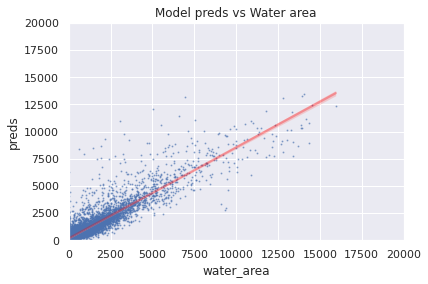

In [29]:
# plot up validation data preds vs measured values
ax = sns.regplot(x="water_area", y="preds", data=val_y,
                 scatter_kws={'s':1, 'alpha':0.5},
                 line_kws={"color": "red",'alpha':0.3}
                )
sns.set(rc={"figure.figsize":(8, 8)})
ax.set(ylim=(0, max_value))
ax.set(xlim=(0, max_value))
ax.set(title='Model preds vs Water area');

In [31]:
# use numpy to calc the line of best fit equation
# note this this looks much better than the scaled factor above
grad, y_intersect = np.polyfit(val_y['water_area'], val_y['preds'], 1)
grad, y_intersect

(0.8374943561759145, 174.42899432325015)

In [32]:
# significant improvment from scaled factor above
model_mea = mean_absolute_error(val_y['water_area'], val_y['preds'])
model_mea

334.0088323928319

In [33]:
model_improvment = 1-(model_mea/466.89)
print(f'the model is {round(model_improvment*100)}% better than the scaled dam area') 

the model is 28% better than the scaled dam area


In [34]:
model_improvment = 1-(model_mea/885.85)
print(f'the model is {round(model_improvment*100)}% better than always guessing water area mean') 

the model is 62% better than always guessing water area mean


In [35]:
# save model to disk
# pickle.dump(xgb_reg, open(model_path, "wb"))
pickle.dump(models, open(model_path, "wb"))

In [36]:
model_path

'/home/nick/Documents/Work code/Dam-Forecast/data/dam_forecast_11-10-22.pkl'